In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
# 目的：スペインの電力価格を予測
# 目的変数：スペインの電力価格(actual_price)
# 評価指標：RME

import numpy as np
import pandas as pd
import os
import pickle
import gc
# 分布確認
!pip install ydata-profiling
from ydata_profiling import ProfileReport
# 可視化
import matplotlib.pyplot as plt
import seaborn as sns
import polars as pl
# 前処理
from sklearn.preprocessing import StandardScaler, MinMaxScaler,LabelEncoder,OneHotEncoder
# モデリング
from sklearn.model_selection import train_test_split,KFold,StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from xgboost import XGBClassifier
import lightgbm as lgb
# 日本語表記
!pip install japanize-matplotlib
import japanize_matplotlib
%matplotlib inline
# パラメータ最適化
!pip install optuna
import optuna

# 評価指標
from sklearn.metrics import mean_squared_error

In [3]:
file_path = '/content/drive/MyDrive/Colab Notebooks/signate/smbc/'

df_train = pd.read_csv(file_path + 'train.csv')
df_test = pd.read_csv(file_path + 'test.csv')
df_sample = pd.read_csv(file_path + 'sample_submit.csv',header=None)

In [4]:
print(df_train.shape)
display(df_train.head())
display(df_train.info())

(26280, 92)


,time,generation_biomass,generation_fossil_brown_coal/lignite,generation_fossil_gas,generation_fossil_hard_coal,generation_fossil_oil,generation_hydro_pumped_storage_consumption,generation_hydro_run_of_river_and_poundage,generation_hydro_water_reservoir,generation_nuclear,...,seville_wind_deg,seville_rain_1h,seville_rain_3h,seville_snow_3h,seville_clouds_all,seville_weather_id,seville_weather_main,seville_weather_description,seville_weather_icon,price_actual
0,2015-01-02 00:00:00+01:00,447.0,329.0,4844.0,4821.0,162.0,863.0,1051.0,1899.0,7096.0,...,33,0.0,0.0,0.0,0,800,clear,sky is clear,01n,64.02
1,2015-01-02 01:00:00+01:00,449.0,328.0,5196.0,4755.0,158.0,920.0,1009.0,1658.0,7096.0,...,33,0.0,0.0,0.0,0,800,clear,sky is clear,01n,58.46
2,2015-01-02 02:00:00+01:00,448.0,323.0,4857.0,4581.0,157.0,1164.0,973.0,1371.0,7099.0,...,44,0.0,0.0,0.0,0,800,clear,sky is clear,01n,54.70
3,2015-01-02 03:00:00+01:00,438.0,254.0,4314.0,4131.0,160.0,1503.0,949.0,779.0,7098.0,...,44,0.0,0.0,0.0,0,800,clear,sky is clear,01n,54.91
4,2015-01-02 04:00:00+01:00,428.0,187.0,4130.0,3840.0,156.0,1826.0,953.0,720.0,7097.0,...,44,0.0,0.0,0.0,0,800,clear,sky is clear,01n,53.07


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26280 entries, 0 to 26279
Data columns (total 92 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   time                                         26280 non-null  object 
 1   generation_biomass                           26259 non-null  float64
 2   generation_fossil_brown_coal/lignite         26260 non-null  float64
 3   generation_fossil_gas                        26260 non-null  float64
 4   generation_fossil_hard_coal                  26260 non-null  float64
 5   generation_fossil_oil                        26259 non-null  float64
 6   generation_hydro_pumped_storage_consumption  26259 non-null  float64
 7   generation_hydro_run_of_river_and_poundage   26259 non-null  float64
 8   generation_hydro_water_reservoir             26260 non-null  float64
 9   generation_nuclear                           26261 non-null  float64
 10

None

In [5]:
print(df_test.shape)
display(df_test.head())
display(df_test.info())

(8760, 91)


,time,generation_biomass,generation_fossil_brown_coal/lignite,generation_fossil_gas,generation_fossil_hard_coal,generation_fossil_oil,generation_hydro_pumped_storage_consumption,generation_hydro_run_of_river_and_poundage,generation_hydro_water_reservoir,generation_nuclear,...,seville_wind_speed,seville_wind_deg,seville_rain_1h,seville_rain_3h,seville_snow_3h,seville_clouds_all,seville_weather_id,seville_weather_main,seville_weather_description,seville_weather_icon
0,2018-01-01 00:00:00+01:00,279.0,0.0,3927.0,895.0,189.0,230.0,1069.0,1893.0,7104.0,...,1,343,0.0,0.0,0.0,0,800,clear,sky is clear,01n
1,2018-01-01 01:00:00+01:00,282.0,0.0,3948.0,878.0,177.0,1269.0,1058.0,1024.0,7101.0,...,1,343,0.0,0.0,0.0,0,800,clear,sky is clear,01n
2,2018-01-01 02:00:00+01:00,283.0,0.0,3791.0,890.0,175.0,2197.0,1052.0,888.0,7100.0,...,1,0,0.0,0.0,0.0,0,800,clear,sky is clear,01n
3,2018-01-01 03:00:00+01:00,280.0,0.0,3671.0,881.0,175.0,2965.0,1032.0,645.0,7101.0,...,1,40,0.0,0.0,0.0,0,800,clear,sky is clear,01n
4,2018-01-01 04:00:00+01:00,286.0,0.0,3460.0,861.0,173.0,2705.0,1001.0,661.0,7101.0,...,1,30,0.0,0.0,0.0,0,800,clear,sky is clear,01n


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 91 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   time                                         8760 non-null   object 
 1   generation_biomass                           8758 non-null   float64
 2   generation_fossil_brown_coal/lignite         8758 non-null   float64
 3   generation_fossil_gas                        8758 non-null   float64
 4   generation_fossil_hard_coal                  8758 non-null   float64
 5   generation_fossil_oil                        8758 non-null   float64
 6   generation_hydro_pumped_storage_consumption  8758 non-null   float64
 7   generation_hydro_run_of_river_and_poundage   8758 non-null   float64
 8   generation_hydro_water_reservoir             8758 non-null   float64
 9   generation_nuclear                           8758 non-null   float64
 10  

None

In [13]:
# 時刻をdatetimeに変換
df_train["time"] = pd.to_datetime(df_train["time"],utc=True)
df_test["time"] = pd.to_datetime(df_test["time"],utc=True)

# 年情報のカラム作成（クロスバリデーション用）
df_train["year"] = df_train["time"].dt.year
df_test["year"] = df_test["time"].dt.year

# ケルビンを摂氏に変換  - 273.15
cities = ["valencia","madrid","bilbao","barcelona","seville"]
for city in cities:
  df_train[f"{city}_temp"] = df_train[f"{city}_temp"] - 273.15
  df_train[f"{city}_temp_min"] = df_train[f"{city}_temp_min"] - 273.15
  df_train[f"{city}_temp_max"] = df_train[f"{city}_temp_max"] - 273.15


# カテゴリカルカラムの抜き出し
categorical_cols = [
    col for col in df_train.select_dtypes(include=['object', 'category']).columns
    if col != "price_actual"
    ]
# 数値カラムの抜き出し
numerical_cols = [
    col for col in df_train.select_dtypes(include=['int64', 'float64']).columns
    ]
print('*'*20,'実行結果確認','*'*20,)
print(f'カテゴリ{categorical_cols}')
print(f'数値{numerical_cols}')


******************** 実行結果確認 ********************
カテゴリ['valencia_weather_main', 'valencia_weather_description', 'valencia_weather_icon', 'madrid_weather_main', 'madrid_weather_description', 'madrid_weather_icon', 'bilbao_weather_main', 'bilbao_weather_description', 'bilbao_weather_icon', 'barcelona_weather_main', 'barcelona_weather_description', 'barcelona_weather_icon', 'seville_weather_main', 'seville_weather_description', 'seville_weather_icon']
数値['generation_biomass', 'generation_fossil_brown_coal/lignite', 'generation_fossil_gas', 'generation_fossil_hard_coal', 'generation_fossil_oil', 'generation_hydro_pumped_storage_consumption', 'generation_hydro_run_of_river_and_poundage', 'generation_hydro_water_reservoir', 'generation_nuclear', 'generation_other', 'generation_other_renewable', 'generation_solar', 'generation_waste', 'generation_wind_onshore', 'total_load_actual', 'valencia_temp', 'valencia_temp_min', 'valencia_temp_max', 'valencia_pressure', 'valencia_humidity', 'valencia_wi

In [24]:
# 訓練データ、テストデータ作成（＝目的変数分離）
x_train = df_train[["year","generation_fossil_hard_coal","generation_fossil_brown_coal/lignite","total_load_actual","generation_fossil_gas"]]
y_train = df_train['price_actual']
x_test = df_test[["year","generation_fossil_hard_coal","generation_fossil_brown_coal/lignite","total_load_actual","generation_fossil_gas"]]

In [27]:

# 交差検証
# FOLDS = 5
# skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=42)
# kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)

# 検証対象年リスト
valid_years = [2016, 2017]

# oof:out of fold/テスト結果格納/スコアリスト
oof = np.zeros(len(y_train))
preds = np.zeros(len(x_test))
rmse_list = []

# パラメータ
params = {
    'boosting_type':'gbdt',
    'objective':'regression',
    'metric':'rmse',
    'learning_rate':0.1,
    'num_leaves':16,
    'n_estimators':10000,
    'random_state':123,
    'importance_type':'gain'
}

# 2パターンに応じてモデルを回す
for i, valid_year in enumerate(valid_years):
  print("#" * 15, f"Fold {i+1}（検証年: {valid_year}）", "#" * 15)

  # 時系列に基づいてインデックス指定
  train_idx = x_train[x_train["year"] < valid_year].index
  valid_idx = x_train[x_train["year"] == valid_year].index

  x_tr, y_tr = x_train.loc[train_idx], y_train.loc[train_idx]
  x_va, y_va = x_train.loc[valid_idx], y_train.loc[valid_idx]

  # モデルを訓練する
  lgb_model = lgb.LGBMRegressor(**params)
  lgb_model.fit(
      x_tr, y_tr,
      eval_set=[(x_va, y_va)],
      callbacks=[
        lgb.early_stopping(stopping_rounds=50), #100に変えてもよいかも
        lgb.log_evaluation(period=10) # verboseの設定
        ]
    )
  # 検証用データに対する予測を書き込む
  y_pred = lgb_model.predict(x_va)
  oof[valid_idx] = y_pred

  # テストデータ予測を累積
  preds += lgb_model.predict(x_test)

  # RMSE を計算（squared=False で平方根を取る）
  mse = mean_squared_error(y_va, y_pred)
  rmse = np.sqrt(mse)
  rmse_list.append(rmse)
  print(f"RMSE: {rmse:.4f}")


# 最後にテスト予測を平均化
preds /= len(valid_years)

print(f'平均 RMSE: {np.mean(rmse_list):.4f}')
print(f'OOF array shape: {oof.shape}')
print(f'Preds array shape: {preds.shape}')

############### Fold 1（検証年: 2016） ###############
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000375 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1011
[LightGBM] [Info] Number of data points in the train set: 8737, number of used features: 4
[LightGBM] [Info] Start training from score 61.358245
Training until validation scores don't improve for 50 rounds
[10]	valid_0's rmse: 17.8362
[20]	valid_0's rmse: 17.53
[30]	valid_0's rmse: 17.5498
[40]	valid_0's rmse: 17.5619
[50]	valid_0's rmse: 17.5888
[60]	valid_0's rmse: 17.674
[70]	valid_0's rmse: 17.7175
Early stopping, best iteration is:
[21]	valid_0's rmse: 17.5075
RMSE: 17.5075
############### Fold 2（検証年: 2017） ###############
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000326 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=t

############### Fold 1（検証年: 2017） ###############
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000362 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1023
[LightGBM] [Info] Number of data points in the train set: 17521, number of used features: 5
[LightGBM] [Info] Start training from score 54.379606
Training until validation scores don't improve for 50 rounds
[10]	valid_0's rmse: 13.6143
[20]	valid_0's rmse: 14.1144
[30]	valid_0's rmse: 14.332
[40]	valid_0's rmse: 14.4066
[50]	valid_0's rmse: 14.4791
Early stopping, best iteration is:
[2]	valid_0's rmse: 13.1563
RMSE: 13.1563
平均 RMSE: 13.1563
OOF array shape: (26280,)
Preds array shape: (8760,)


<ipython-input-31-35578851>:80: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='gain', y='feature', data=feature_importance.head(20), palette='viridis')


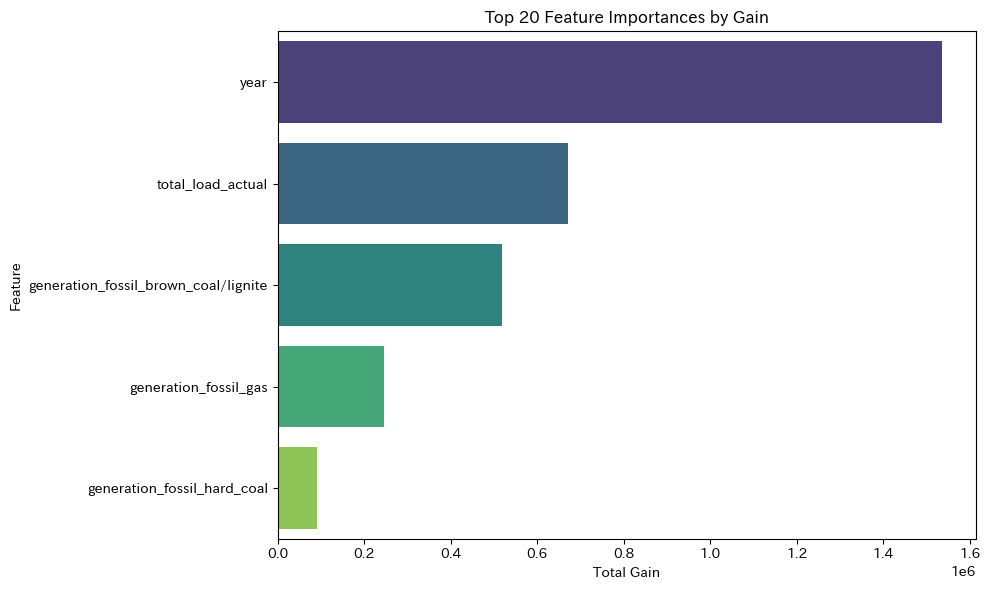

In [31]:

# 交差検証
# FOLDS = 5
# skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=42)
# kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)

# 検証対象年リスト
valid_years = [2017]

# oof:out of fold/テスト結果格納/スコアリスト
oof = np.zeros(len(y_train))
preds = np.zeros(len(x_test))
rmse_list = []

# パラメータ
params = {
    'boosting_type':'gbdt',
    'objective':'regression',
    'metric':'rmse',
    'learning_rate':0.1,
    'num_leaves':16,
    'n_estimators':10000,
    'random_state':123,
    'importance_type':'gain'
}

# 2パターンに応じてモデルを回す
for i, valid_year in enumerate(valid_years):
  print("#" * 15, f"Fold {i+1}（検証年: {valid_year}）", "#" * 15)

  # 時系列に基づいてインデックス指定
  train_idx = x_train[x_train["year"] < valid_year].index
  valid_idx = x_train[x_train["year"] == valid_year].index

  x_tr, y_tr = x_train.loc[train_idx], y_train.loc[train_idx]
  x_va, y_va = x_train.loc[valid_idx], y_train.loc[valid_idx]

  # モデルを訓練する
  lgb_model = lgb.LGBMRegressor(**params)
  lgb_model.fit(
      x_tr, y_tr,
      eval_set=[(x_va, y_va)],
      callbacks=[
        lgb.early_stopping(stopping_rounds=50), #100に変えてもよいかも
        lgb.log_evaluation(period=10) # verboseの設定
        ]
    )
  # 検証用データに対する予測を書き込む
  y_pred = lgb_model.predict(x_va)
  oof[valid_idx] = y_pred

  # テストデータ予測を累積
  preds += lgb_model.predict(x_test)

  # RMSE を計算（squared=False で平方根を取る）
  mse = mean_squared_error(y_va, y_pred)
  rmse = np.sqrt(mse)
  rmse_list.append(rmse)
  print(f"RMSE: {rmse:.4f}")


# 最後にテスト予測を平均化
preds /= len(valid_years)

print(f'平均 RMSE: {np.mean(rmse_list):.4f}')
print(f'OOF array shape: {oof.shape}')
print(f'Preds array shape: {preds.shape}')

# 特徴量名とimportanceを取得
feature_importance = pd.DataFrame({
    'feature': x_tr.columns,
    'importance': lgb_model.feature_importances_,  # splitの数
    'gain': lgb_model.booster_.feature_importance(importance_type='gain')  # gain値
})

# ソート
feature_importance = feature_importance.sort_values('gain', ascending=False)

# 上位20個をプロット
plt.figure(figsize=(10, 6))
sns.barplot(x='gain', y='feature', data=feature_importance.head(20), palette='viridis')
plt.title("Top 20 Feature Importances by Gain")
plt.xlabel("Total Gain")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

In [30]:
from datetime import date

today = date.today()

df_sub = pd.read_csv(file_path + 'sample_submit.csv',header=None)

submission = pd.DataFrame({
    'time':df_sub.iloc[:, 0] ,
    'pred': preds
})
submission.to_csv(f'submission_{today}.csv', index=False, header=False)
print(f'✅ Submission file saved as submission_{today}.csv')

✅ Submission file saved as submission_2025-06-14.csv
